In [1]:
import numpy as np
from scipy.integrate import odeint
import scipy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import json
import pylab

import matplotlib
%matplotlib inline


In [2]:
#Get data from Graber et al paper

def get_data(file_path):
    arr=json.load(open(file_path))['datasetColl'][0]['data']
    x=np.array([arr[i]['value'][0] for i in range(len(arr))])
    y=np.array([arr[i]['value'][1] for i in range(len(arr))])
    return x,y

Xtemp,Ytemp=get_data('../data/withdrawal/prior/wpd.json')
Xbaseline,Ybaseline=Xtemp[5:],Ytemp[5:]
Xprior,Yprior=Xtemp[:5],Ytemp[:5]
X1months,Y1months=get_data('../data/withdrawal/1months/wpd.json')
X2months,Y2months=get_data('../data/withdrawal/2months/wpd.json')
X25months,Y25months=get_data('../data/withdrawal/2-5months/wpd.json')
X59months,Y59months=get_data('../data/withdrawal/5-9months/wpd.json')
Xmore9months,Ymore9months=get_data('../data/withdrawal/more9months/wpd.json')


time_data=np.array([-1,15,45,105,200,300])
time_err=np.array([0,15,15,45,60,30])
ACTH_data=np.log10(np.array([np.mean(Xprior),np.mean(X1months),np.mean(X2months),\
                        np.mean(X25months),np.mean(X59months),np.mean(Xmore9months)])/np.mean(Xbaseline))
cort_data=np.array([np.mean(Yprior),np.mean(Y1months),np.mean(Y2months),\
                        np.mean(Y25months),np.mean(Y59months),np.mean(Ymore9months)])/np.mean(Ybaseline)

ACTH_std=np.array([np.std(np.log10(Xprior))/len(Xprior)**0.5,\
                   np.std(np.log10(X1months))/len(X1months)**0.5,\
                   np.std(np.log10(X2months))/len(X2months)**0.5,\
                   np.std(np.log10(X25months))/len(X25months)**0.5,\
                   np.std(np.log10(X59months))/len(X59months)**0.5,\
                   np.std(np.log10(Xmore9months))/len(Xmore9months)**0.5])\
                   /np.mean(Xbaseline)
    
cort_std=np.array([np.std(Yprior)/len(Yprior)**0.5,\
                   np.std(Y1months)/len(Y1months)**0.5,\
                   np.std(Y2months)/len(Y2months)**0.5,\
                   np.std(Y25months)/len(Y25months)**0.5,\
                   np.std(Y59months)/len(Y59months)**0.5,\
                   np.std(Ymore9months)/len(Ymore9months)**0.5])/np.mean(Ybaseline)

time_data1=np.array([-1,15,45,105,200,300])/30
time_err1=np.array([0,15,15,45,60,30])
ACTH_data1=np.array([np.mean(Xprior),np.mean(X1months),np.mean(X2months),\
                        np.mean(X25months),np.mean(X59months),np.mean(Xmore9months)])
cort_data1=np.array([np.mean(Yprior),np.mean(Y1months),np.mean(Y2months),\
                        np.mean(Y25months),np.mean(Y59months),np.mean(Ymore9months)])



In [3]:
def get5eqsparams(timescale='day'):
    #parameters are from the paper Mathematical modeling of the hypothalamic-pituitary-adrenal gland (HPA) axis, including hippocampal mechanisms.
    #Andersen M1, Vinther F, Ottesen JT.
    
    a1=0.1731 #[1/min]
    a2=0.0348 #[1/min]
    a3=0.009071 #[1/min]

    #mitosis every 63 days according to Nolan et al
    #aP=1/63/(60*24)
    
    #aP=1/30/(60*24)#prev one
    aP=1/15/(60*24)
    
    
    # turnover of 60 days according to Kataoka et al
    #aA=1/60/(60*24)#prev one
    aA=1/60/(60*24)

    
    #We normalize all means to 1, we therefore get
    b1=a1;b2=a2;b3=a3;bA=aA;bP=aP;
    
    res=np.array([a1,a2,a3,aA,aP,b1,b2,b3,bA,bP])
    
    if timescale=='hour':
        res=60*res
    
    if timescale=='day':
        res=24*60*res
    
    return res






def plotDataAndTheory(HPAeqs,save_path=None):
    '''
    This function get as input the function of HPA differential equations
    ans plots the figure
    '''
    def_color=plt.rcParams['axes.color_cycle']
    matplotlib.rcParams.update({'font.size': 18})

    #Simulate the circuit
    k=300
    t_seg=np.linspace(0,k-1,k)
    
    #Initial conditions for A and P
    AA=0.01
    PP=0.0001 
    sol=odeint(lambda y,t:HPAeqs(y,t,timescale='day',external=0),\
               [AA**(-1/3)*PP**(-1/3),AA**(-2/3)*PP**(1/3),AA**(1/3)*PP**(1/3),AA,PP],t_seg)
    
    #Plot the simulation
    fig, ax = plt.subplots(2,1,figsize=(6,8))
    ax1=ax[0]
    ax1.text(-0.15, 1.1, 'A', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')


    ax1.set_xlabel('Time [month]')
    ax1.plot(t_seg/30,sol[:,1],linestyle='-',color=def_color[1])
    ax1.tick_params(axis='y', labelcolor=def_color[1])
    ax1.set_ylabel('Normalised ACTH',color=def_color[1])
    ax1.set_yscale('log')
    plt.axvline(x=0,color='black')
    ax1.set_ylim([10**(-0.5),10**1.5])


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(t_seg/30,sol[:,2],linestyle='-',color=def_color[0])
    ax2.tick_params(axis='y', labelcolor=def_color[0])
    ax2.set_ylabel('Normalised Cortisol',color=def_color[0])

    #Plot the data
    ax1=ax[1]
    ax1.text(-0.205, 1.1, 'B', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')


    color = def_color[1]
    ax1.set_xlabel('Time [Month]')
    ax1.set_ylabel('ACTH [mU/dL]', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    errplus=10**(np.log10(ACTH_data1)+ACTH_std)-ACTH_data1
    errminus=ACTH_data1-10**(np.log10(ACTH_data1)-ACTH_std)
    err_bar=[errminus,errplus]
    ax1.errorbar(time_data/30,ACTH_data1,yerr=err_bar,xerr=time_err/30,linestyle='-', color=color,markersize=20,marker='.')
    ax1.set_yscale('log')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = def_color[0]
    ax2.set_ylabel('Cortisol [$\mu$g/dL]', color=color)  # we already handled the x-label with ax1
    ax2.errorbar(time_data[1:]/30,cort_data1[1:],yerr=cort_std[1:],xerr=time_err[1:]/30,linestyle='-', color=color,markersize=20,marker='.')

    ax2.tick_params(axis='y', labelcolor=color)

    plt.axvline(x=0,color='black')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if save_path:
        plt.savefig(save_path,bbox_inches='tight',dpi=600)
    plt.show()




/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


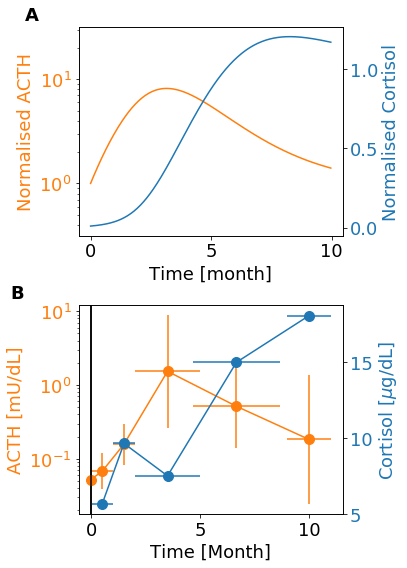

In [4]:
'''
This is Figure 4 of the paper (in the 14.3.19 version)
The HPA model under steroid withdrawal conditions
'''
def HPASimulationCRH_CC(y,t,timescale='day',external=0):
    '''This function simulates the HPA axis while CRH is the trophic factor
    for pituitary and there is a carrying capacity on the glands'''
    [a1_,a2_,a3_,aA_,aP_,b1_,b2_,b3_,bA_,bP_]=get5eqsparams(timescale)
    [x1_,x2_,x3_,A_,P_]=y
    dy=np.empty(5)
    u_=1
   
    dy[0]= u_*b1_/(x3_+external)-a1_*x1_ #CRH
    dy[1]= b2_*x1_*P_/(x3_+external)-a2_*x2_ #ACTH
    dy[2]= b3_*x2_*A_-a3_*x3_ #Cortisol
    dy[3]= A_*(bA_*3*x2_/(x2_+2)-aA_) #Adrenal cells
    dy[4]= P_*(bP_*3*x1_/(x1_+2)-aP_) #Pituitary cells    
    return dy 

plotDataAndTheory(HPASimulationCRH_CC,save_path='../figures/withdrawal_CRH_CC.pdf')

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


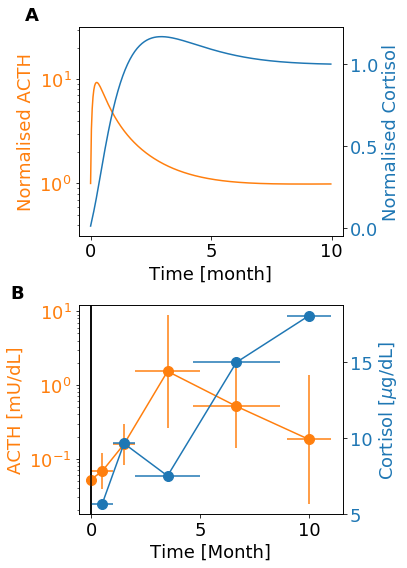

In [5]:
'''
This is Figure S5 of the SI (in the 14.3.19 version)
The HPA model without carrying capacity in withdrawal
'''

def HPASimulationCRH_NoCC(y,t,timescale='day',external=0):
    '''This function simulates the HPA axis while CRH is the trophic factor
    for pituitary and there is no carrying capacity on the glands'''
    [a1_,a2_,a3_,aA_,aP_,b1_,b2_,b3_,bA_,bP_]=get5eqsparams(timescale)
    [x1_,x2_,x3_,A_,P_]=y
    dy=np.empty(5)
    u_=1
   
    dy[0]= u_*b1_/(x3_+external)-a1_*x1_ #CRH
    dy[1]= b2_*x1_*P_/(x3_+external)-a2_*x2_ #ACTH
    dy[2]= b3_*x2_*A_-a3_*x3_ #Cortisol
    dy[3]= A_*(bA_*x2_-aA_) #Adrenal cells
    dy[4]= P_*(bP_*x1_-aP_) #Pituitary cells    
    return dy

plotDataAndTheory(HPASimulationCRH_NoCC,save_path='../figures/withdrawal_CRH_noCC.pdf')

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


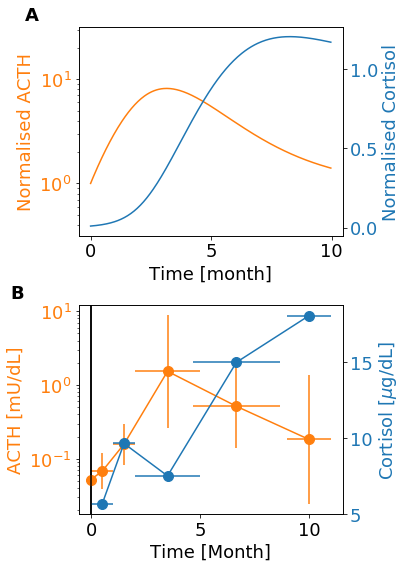

In [6]:
'''
This is Figure S7 of the SI (in the 14.3.19 version)
Withdrawal in an anti-trophic cortisol model
Results are exactly the same as CRH, this is explained in the SI
'''


def HPASimulationCortisol(y,t,timescale='day',external=0):
    '''This function simulates the HPA axis while cortisol is anti-trophic factor
    for pituitary and there is a carrying capacity on the glands'''
    [a1_,a2_,a3_,aA_,aP_,b1_,b2_,b3_,bA_,bP_]=get5eqsparams(timescale)
    [x1_,x2_,x3_,A_,P_]=y
    dy=np.empty(5)
    u_=1
   
    dy[0]= u_*b1_/(x3_+external)-a1_*x1_ #CRH
    dy[1]= b2_*x1_*P_/(x3_+external)-a2_*x2_ #ACTH
    dy[2]= b3_*x2_*A_-a3_*x3_ #Cortisol
    dy[3]= A_*(bA_*3*x2_/(x2_+2)-aA_) #Adrenal cells
    dy[4]= P_*(bP_*3*(1/x3_)/((1/x3_)+2)-aP_) #Pituitary cells    
    return dy 

plotDataAndTheory(HPASimulationCortisol,save_path='../figures/withdrawal_cort_CC.pdf')